# Clustering in UMAP space

This script generates and evaluates clustering on a given UMAP representation.

#### The project directory should have at least the following structure and files:
    
    ├── data
    │   ├── df.pkl          <- pickled pandas dataframe with metadata and UMAP coordinates 
    ├── parameters 
    │   ├── spec_params.py  <- python file containing the spectrogram parameters used (generated in 
    |                           01_generate_spectrograms.ipynb)
    ├── parameters         
    ├── functions           <- the folder with the function files provided in the repo                
    ├── notebooks           <- the folder with the notebook files provided in the repo    
    ├── ...  


#### The following columns must exist (somewhere) in the pickled dataframe df.pkl:

    | filename   | spectrograms    |  samplerate_hz |    label
    --------------------------------------------------------------------
    | call_1.wav |  2D np.array    |      8000      |    A 
    | call_2.wav |  ...            |      48000     |    B 
    | ...        |  ...            |      ....      |    unknown
    
#### The following files are generated in this script:

None.

[Plots can be saved as img files if desired]

# Imports, functions and constants

In [2]:
import os
import pandas as pd
import numpy as np
import json
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import hdbscan
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
import scipy
import sys 
sys.path.insert(0, '..')

from functions.plot_functions import umap_3Dplot, plotly_viz

%matplotlib inline

In [3]:
# Import functions for calculating unadjusted Rand score
# Resource: https://stackoverflow.com/questions/49586742/rand-index-function-clustering-performance-evaluation

def rand_index_score(clusters, classes):
    tp_plus_fp = scipy.special.comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum() for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)
    
def calc_rand(pred, true):
    classnames, pred = np.unique(pred, return_inverse=True)
    classnames, true = np.unique(true, return_inverse=True)
    return rand_index_score(pred, true)

distinct_colors_22 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                      '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                      '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                      '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
                      '#ffffff', '#000000']

In [4]:
# Set project directory and column name of label variable
P_DIR = str(Path(os.getcwd()).parents[0])            # project directory
LABEL_COL = 'label'                                  # Column name of label variable

# Load dataframe with UMAP coordinates
df = pd.read_pickle(os.path.join(os.path.sep, P_DIR, 'data', 'df_umap.pkl'))

# Detect columns with UMAP coordinates
UMAP_COLS = [x for x in df.columns if 'UMAP' in x]   

# Save labels and embedding as variables
labels = df[LABEL_COL]                               # labels
embedding = np.asarray(df[UMAP_COLS])                # UMAP coordinates

print("Found ", len(UMAP_COLS), "UMAP columns. Label in column : ", LABEL_COL)

Found  3 UMAP columns. Label in column :  label


# Clustering

The aim here is to cluster the vocalizations into distinct categories based on the UMAP coordinates.
We use Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) to obtain high-confidence clusters, at the expense of leaving some datapoints unassigned ("Noise").

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html


In [5]:
# clustering
HDBSCAN = hdbscan.HDBSCAN(min_cluster_size=int(0.01*embedding.shape[0]),
                          cluster_selection_method = 'leaf').fit(embedding)
hdb_labels = HDBSCAN.labels_ # these are the predicted clusters labels
df['HDBSCAN'] = hdb_labels   # add predicted cluster labels to dataframe

In [6]:
# For some evaluations, it makes sense to remove the datapoints labelled as noise
# "Noise" datapoints are by default labelled as -1 by HDBSCAN

hdb_labels_no_noise = hdb_labels.copy()
assigned = np.full((len(hdb_labels_no_noise),), False)
assigned[np.where(hdb_labels_no_noise!=-1)[0]] = True

hdb_labels_no_noise = hdb_labels_no_noise[assigned] # the predicted cluster labels without noise datapoints
df_no_noise = df.loc[assigned]                           # the dataframe without noise datapoints
embedding_no_noise = embedding[assigned,:]               # the UMAP coordinates without noise datapoints

# Cluster evaluation 

## 1. Agreement between automated clusters and manual labels: RI, ARI, SIL

We then assess the agreement between the clusters obtained from HDBSCAN and the manual call type labels using adjusted (ARI), unadjusted Rand index (RI) and the Silhouette score (SIL). We chose ARI and RI for their ease of interpretation, but there are many alternative and equally suitable metrics for comparing partitions (e.g. Mutual Information Score). 

RI is used to compare two clusterings X and Y and is defined as:

>RI = (a+b) / (a+b+c+d)

with 
- a the number of pairs of datapoints that are in the same subset in X and the same subset in Y 
- b the number of pairs of datapoints that are in different subsets in X and different subsets in Y
- c the number of pairs of datapoints that are in different subsets in X and in the same subset in Y  
- d the number of pairs of datapoints that are in the same subset in X and in different subsets in Y  

Hence, 100 % agreement between two clusterings results in RI = 1. As even two random clusterings would have RI > 0 due to random chance alone, it is recommended to use ARI, the corrected-for-chance version of RI, where ARI=0 means that the agreement is no better than the random chance expectation. 


In [7]:
# evaluate clustering 

print("************************")
print("HDBSCAN:")
print("************************")
cluster_labels = hdb_labels
true_labels = df[LABEL_COL]
embedding_data = embedding


print("RI: ", calc_rand(cluster_labels, true_labels))
print("ARI: ", adjusted_rand_score(cluster_labels, true_labels))
print("SIL: ", silhouette_score(embedding_data, cluster_labels))
print("N_clust: ", len(list(set(cluster_labels))))

print(" ")

print("************************")
print("HDBSCAN-no-noise:")
print("************************")
cluster_labels = hdb_labels_no_noise
true_labels = df_no_noise[LABEL_COL]
embedding_data = embedding_no_noise


print("RI: ", calc_rand(cluster_labels, true_labels))
print("ARI: ", adjusted_rand_score(cluster_labels, true_labels))
print("SIL: ", silhouette_score(embedding_data, cluster_labels))
print("N_clust: ", len(list(set(cluster_labels))))


************************
HDBSCAN:
************************
RI:  0.6482399770182362
ARI:  0.08236951003870956
SIL:  -0.1267448
N_clust:  15
 
************************
HDBSCAN-no-noise:
************************
RI:  0.85471183265829
ARI:  0.4392637357644332
SIL:  0.5871556
N_clust:  14


## 2. Visualization

### HDBSCAN labels

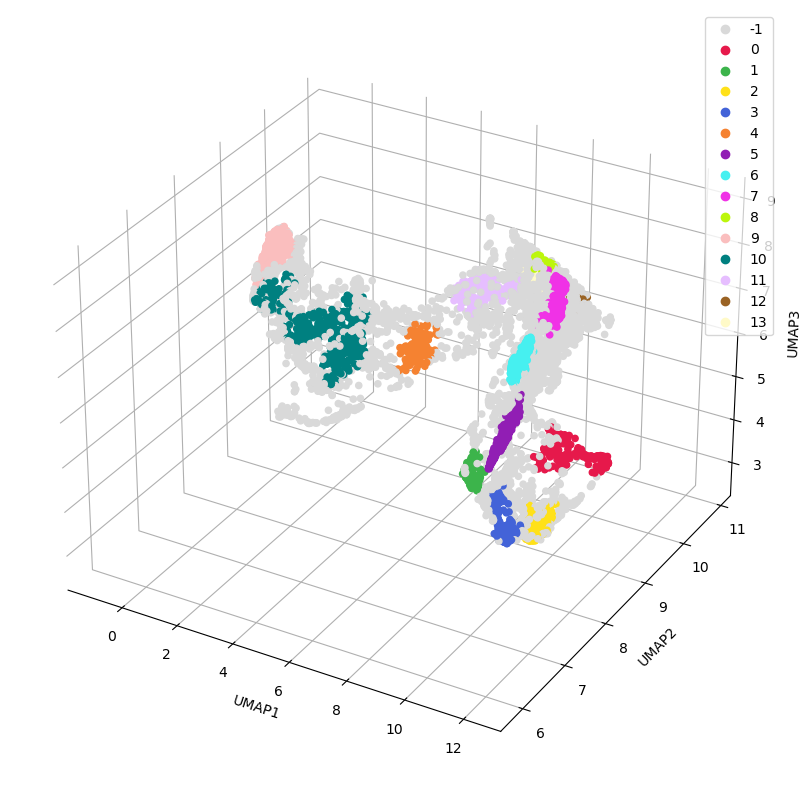

In [8]:
hdb_colors = ['#d9d9d9'] + distinct_colors_22

umap_3Dplot(x=df['UMAP1'],              # xaxis coordinates
            y=df['UMAP2'],              # yaxis coordinates
            z=df['UMAP3'],              # zaxis coordinates
            scat_labels=hdb_labels,     # labels (if available)
            mycolors=hdb_colors,        #  sns.Palette color scheme name or list of colors
            outname=None,               # filename (with path) where figure will be saved. Default: None -> figure not saved
            showlegend=True)            # show legend if True else no legend

### Original labels

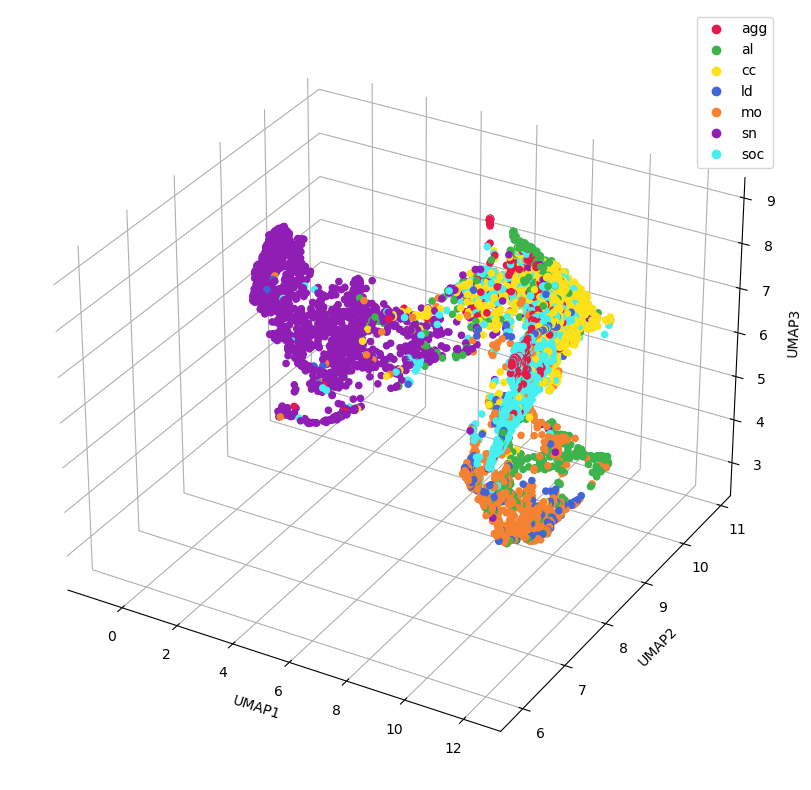

In [10]:
umap_3Dplot(x=df['UMAP1'],              # xaxis coordinates
            y=df['UMAP2'],              # yaxis coordinates
            z=df['UMAP3'],              # zaxis coordinates
            scat_labels=labels,         # labels (if available)
            mycolors=distinct_colors_22,#  sns.Palette color scheme name or list of colors
            outname=None,               # filename (with path) where figure will be saved. Default: None -> figure not saved
            showlegend=True)            # show legend if True else no legend

### Example spectrograms for each HDBSCAN cluster

In [10]:
DISPLAY_COL = 'spectrograms' # column name of spectrogram to display (denoised_spectrograms, spectrograms...)

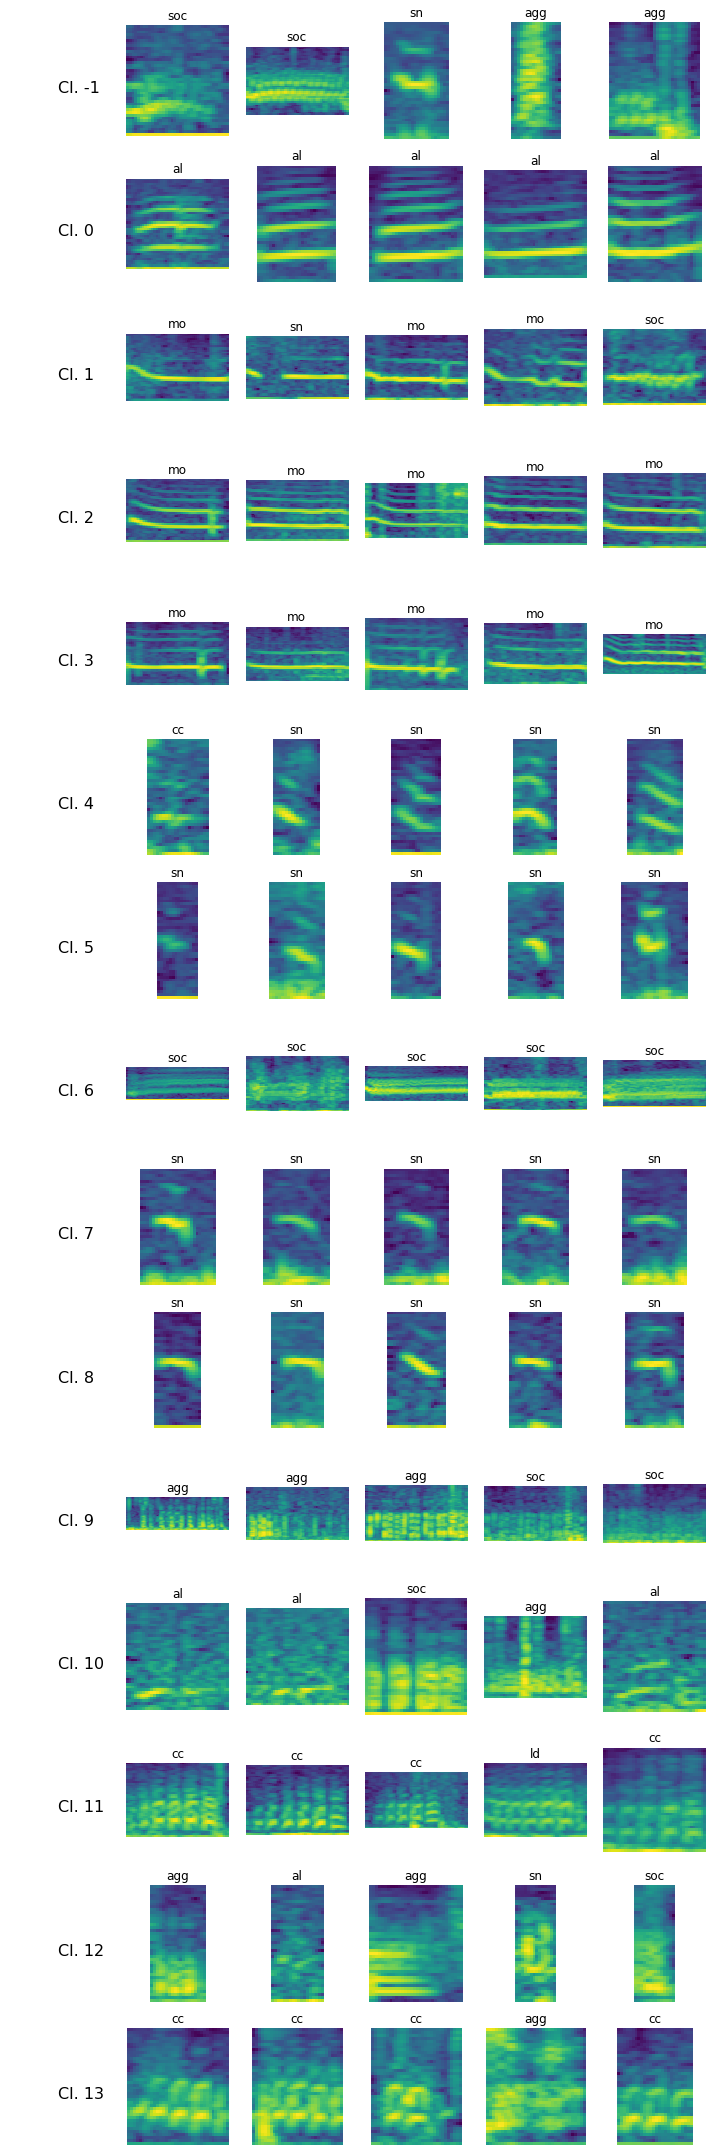

In [11]:
n_specs=5
clusters = sorted(list(set(hdb_labels)))

plt.figure(figsize=(n_specs*2, len(clusters)*2))

k=1
specs = {}

for cluster in clusters:
    example = df[df['HDBSCAN']==cluster].sample(n = n_specs, random_state=2204)
    specs = example[DISPLAY_COL].values
    labels = example[LABEL_COL].values
    i=0 
    
    plt.subplot(len(clusters), n_specs+1, k)
    k+=1    
    plt.axis('off')
    plt.text(0.5,0.4, 'Cl. '+str(cluster), fontsize=16)
    
    
    
    for spec, label in zip(specs, labels):
        plt.subplot(len(clusters), n_specs+1, k)
        plt.imshow(spec, interpolation='nearest', aspect='equal', origin='lower')
        plt.axis('off')
        title = str(label)
        plt.title(title)
        k += 1

plt.tight_layout()

## 3. Cluster content analysis

We can also investigate the composition of clusters in more detail.
In this example, we investigate what call types constitute the different clusters, but other variables, such as individual identity or species could also be used.

### 3.1. Cluster composition (in absolute numbers)

The following plot shows the absolute numbers of datapoints labelled j (columns), in cluster i (row).

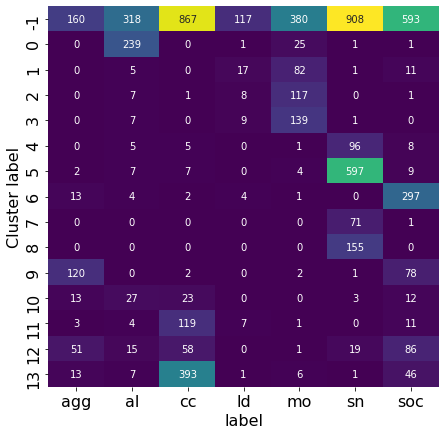

In [12]:
analyze_by = LABEL_COL       # Column name of variable by which to analyze cluster content. 
                             # Select any variable of interest in DF

cluster_labels = hdb_labels  # Variable of cluster labels


cluster_labeltypes = sorted(list(set(cluster_labels)))
by_types = sorted(list(set(df[analyze_by])))
stats_tab = np.zeros((len(cluster_labeltypes), len(by_types)))
for i,clusterlabel in enumerate(cluster_labeltypes):
    label_df = df.loc[cluster_labels==clusterlabel]
    for j, by_type in enumerate(by_types):
        stats_tab[i,j] = sum(label_df[analyze_by]==by_type)

stats_tab_df = pd.DataFrame(stats_tab, index=cluster_labeltypes, columns=by_types)

# absolute vals
plt.figure(figsize=(int(len(cluster_labeltypes)/2), int(len(by_types))))
ax = sns.heatmap(stats_tab_df, annot=True, cmap='viridis', fmt='.0f', cbar=False)
ax.set_xlabel(analyze_by, fontsize=16)
ax.set_ylabel("Cluster label", fontsize=16) 
ax.tick_params(labelsize=16)

### 3.2. Cluster composition (in %)

The following plot shows the composition of clusters in percentage (each row sums up to 100 %).

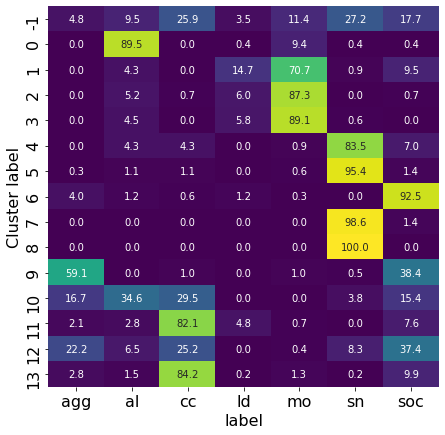

In [13]:
# rowsums
stats_tab_norm = np.zeros((stats_tab.shape))
rowsums = np.sum(stats_tab, axis=1)
for i in range(stats_tab.shape[0]):
    stats_tab_norm[i,:] = stats_tab[i,:]/rowsums[i]
    
stats_tab_norm_df = pd.DataFrame(stats_tab_norm, index=cluster_labeltypes, columns=by_types) * 100

plt.figure(figsize=(int(len(cluster_labeltypes)/2), int(len(by_types))))
ax = sns.heatmap(stats_tab_norm_df, annot=True, cmap='viridis', fmt='.1f', cbar=False)
ax.set_xlabel(analyze_by, fontsize=16)
ax.set_ylabel("Cluster label", fontsize=16) 
ax.tick_params(labelsize=16)

### 3.3 Distribution of variables into clusters

The following plot shows the distribution of the analysis variable into clusters in percentage (each column sums up to 100 %).

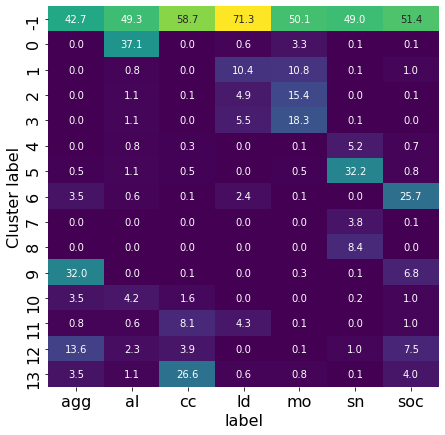

In [14]:
# colsums
stats_tab_norm = np.zeros((stats_tab.shape))
colsums = np.sum(stats_tab, axis=0)
for i in range(stats_tab.shape[1]):
    stats_tab_norm[:,i] = stats_tab[:,i]/colsums[i]
    
stats_tab_norm_df = pd.DataFrame(stats_tab_norm, index=cluster_labeltypes, columns=by_types) * 100

plt.figure(figsize=(int(len(cluster_labeltypes)/2), int(len(by_types))))
ax = sns.heatmap(stats_tab_norm_df, annot=True, cmap='viridis', fmt='.1f', cbar=False)
ax.set_xlabel(analyze_by, fontsize=16)
ax.set_ylabel("Cluster label", fontsize=16) 
ax.tick_params(labelsize=16)